## Project of Pattern Recognition

In [1]:
# Face datasets from sklearn
from sklearn.datasets import fetch_lfw_people

# Data visualization tool
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ndarray
import numpy as np

# skimage for image processing
from skimage import exposure

# For measure time cost
from time import time

# Classification report 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
ori_faces = fetch_lfw_people(min_faces_per_person=50)

n_sample, h, w = ori_faces.images.shape
n_features = ori_faces.data.shape[1]
data_shape = ori_faces.data.shape
target_names = ori_faces.target_names
n_classes = len(target_names)

print('Total number of sample: {}'.format(n_sample))
print('Image size: {} x {}'.format(h, w))
print("Total features per IMG: {}".format(n_features))
print("DataFrame shape: {}".format(data_shape))
print('Target names: {}'.format(target_names))
print('Total classes: {}'.format(n_classes))

Total number of sample: 1560
Image size: 62 x 47
Total features per IMG: 2914
DataFrame shape: (1560, 2914)
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
Total classes: 12


Done in: 0.812s


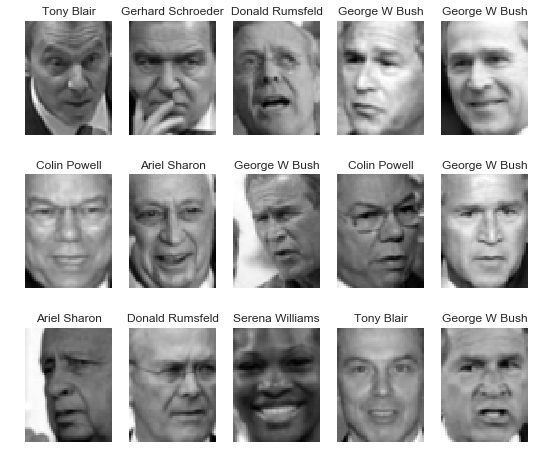

In [3]:
st_time = time()

fig, ax = plt.subplots(3, 5, figsize=(9, 8))

for i, axi in enumerate(ax.flat):
    axi.imshow(ori_faces.images[i], cmap='gray')
    axi.set_title(ori_faces.target_names[ori_faces.target[i]])
    axi.axis('off')

print('Done in: {:0.3f}s'.format(time()-st_time))

In [4]:
# st_time = time()

# ori_faces.images = exposure.equalize_hist(ori_faces.images)

# fig, ax = plt.subplots(3, 5, figsize=(9, 8))

# for i, axi in enumerate(ax.flat):
#     axi.imshow(ori_faces.images[i], cmap='gray')
#     axi.set_title(ori_faces.target_names[ori_faces.target[i]])
#     axi.axis('off')
    
# print('Done in: {:0.3f}s'.format(time()-st_time))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    ori_faces.data, 
    ori_faces.target,
    random_state=42 # random_state is the seed used by the random number generator
)

We want to choose min pca component, from the plot we can see the range.

In [6]:
from sklearn.decomposition import PCA

Done in: 2.626s


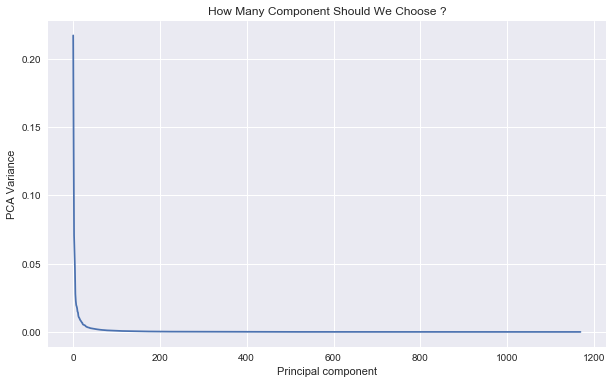

In [7]:
st_time = time()

pca = PCA(svd_solver='randomized', whiten=True).fit(X_train)

plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_ / sum(pca.explained_variance_))
plt.xlabel('Principal component')
plt.ylabel('PCA Variance')
plt.title('How Many Component Should We Choose ?')
plt.grid(True)

print('Done in: {:0.3f}s'.format(time()-st_time))

Done in: 0.261s


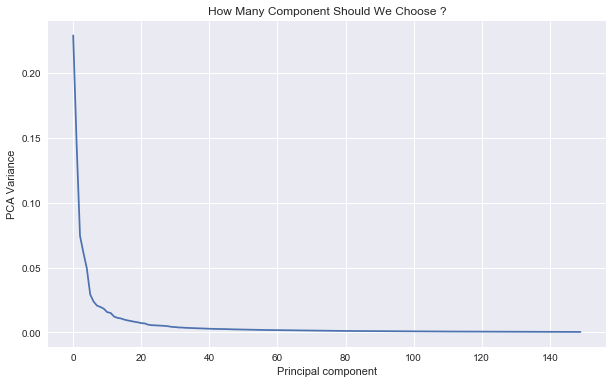

In [8]:
st_time = time()

pca = PCA(n_components=150, svd_solver='randomized', whiten=True).fit(X_train)

plt.figure(figsize=(10,6))
plt.plot(pca.explained_variance_ / sum(pca.explained_variance_))
plt.xlabel('Principal component')
plt.ylabel('PCA Variance')
plt.title('How Many Component Should We Choose ?')
plt.grid(True)

print('Done in: {:0.3f}s'.format(time()-st_time))

In [9]:
st_time = time()

n_components = 120

print("Extracting the top {} component from train set of {} faces.".format(n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Done in: {:0.3f}s'.format(time()-st_time))

Extracting the top 120 component from train set of 1170 faces.
Done in: 0.178s


C is the penalty error that governs to what degree the model is allowed to misclassify As C approaches infinity, the model approaches standalone state When C is small, the model is allowed to misclassify to higher degree.
As gamma increases, the RBF is given more degrees of freedom A high gamma increases liklihood of overfitting, which is why we use grid search

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

st_time = time()

param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svc = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid_svc)
svc = svc.fit(X_train_pca, y_train)
svc_predict = svc.predict(X_test_pca)

print(svc.best_estimator_)
print(classification_report(y_test, svc_predict, target_names=ori_faces.target_names))
print('Accuracy Score: {:0.3f}%'.format(accuracy_score(y_test, svc_predict)*100))
print('Done in: {:0.3f}s'.format(time()-st_time))

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
                   precision    recall  f1-score   support

     Ariel Sharon       0.61      0.69      0.65        16
     Colin Powell       0.80      0.89      0.84        66
  Donald Rumsfeld       0.62      0.74      0.68        27
    George W Bush       0.94      0.76      0.84       140
Gerhard Schroeder       0.71      0.83      0.77        24
      Hugo Chavez       0.73      0.65      0.69        17
   Jacques Chirac       0.62      0.50      0.56        10
    Jean Chretien       0.76      0.93      0.84        14
    John Ashcroft       0.76      0.81      0.79        16
Junichiro Koizumi       0.80      0.73      0.76        11
  Serena Williams       0.73      0.89      0.80         9
       Tony Blair       0.80      0.93      0.86        40

  

In [11]:
from sklearn import neighbors

st_time = time()

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}

knn = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid_knn)
knn.fit(X_train_pca, y_train)
knn_predict = knn.predict(X_test_pca)

print(knn.best_estimator_)
print(classification_report(y_test, knn_predict, target_names=ori_faces.target_names))
print('Accuracy Score: {:0.3f}%'.format(accuracy_score(y_test, knn_predict)*100))
print('Done in: {:0.3f}s'.format(time()-st_time))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
                   precision    recall  f1-score   support

     Ariel Sharon       0.58      0.44      0.50        16
     Colin Powell       0.61      0.61      0.61        66
  Donald Rumsfeld       0.40      0.44      0.42        27
    George W Bush       0.67      0.74      0.71       140
Gerhard Schroeder       0.53      0.42      0.47        24
      Hugo Chavez       0.77      0.59      0.67        17
   Jacques Chirac       0.50      0.30      0.37        10
    Jean Chretien       0.60      0.43      0.50        14
    John Ashcroft       0.55      0.69      0.61        16
Junichiro Koizumi       0.78      0.64      0.70        11
  Serena Williams       1.00      0.56      0.71         9
       Tony Blair       0.56      0.62      0.59        40

      avg / total       0.62      0.62      0.61       390

Accurac

In [12]:
from sklearn.neural_network import MLPClassifier

st_time = time()

param_grid_mlp = {
    'hidden_layer_sizes': [10, 50, 100, 125, 150, 200, 300]
}

mlp = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=42), param_grid_mlp)
mlp.fit(X_train_pca, y_train)
mlp_predict = mlp.predict(X_test_pca)

print(mlp.best_estimator_)
print(classification_report(y_test, mlp_predict, target_names=ori_faces.target_names))
print('Accuracy Score: {:0.3f}%'.format(accuracy_score(y_test, mlp_predict)*100))
print('Done in: {:0.3f}s'.format(time()-st_time))

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=150, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
                   precision    recall  f1-score   support

     Ariel Sharon       0.63      0.75      0.69        16
     Colin Powell       0.92      0.86      0.89        66
  Donald Rumsfeld       0.66      0.70      0.68        27
    George W Bush       0.93      0.82      0.87       140
Gerhard Schroeder       0.64      0.75      0.69        24
      Hugo Chavez       0.73      0.65      0.69        17
   Jacques Chirac       0.60      0.60      0.60        10
    Jean Chretien       0.69      0.79      0.73        14
    John Ashcroft       0.75      0.94 

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat_1 = confusion_matrix(y_test, svc_predict)
mat_2 = confusion_matrix(y_test, knn_predict)
mat_3 = confusion_matrix(y_test, mlp_predict)

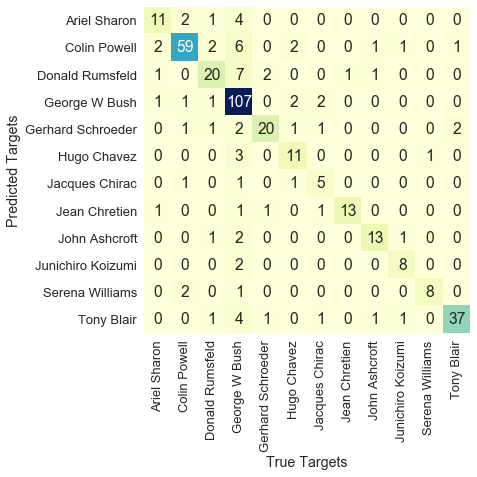

In [14]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.3)
sns.heatmap(mat_1.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="YlGnBu")
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets');

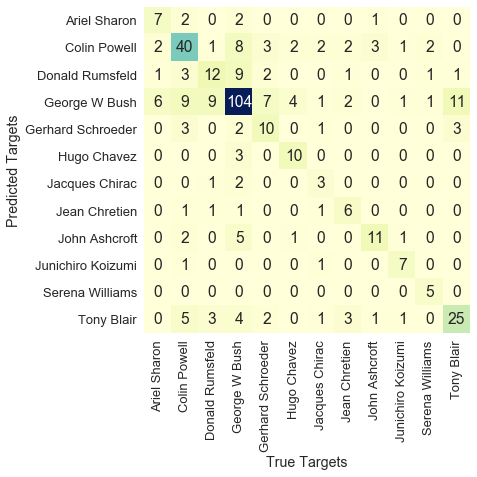

In [15]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.3)
sns.heatmap(mat_2.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="YlGnBu")
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets');

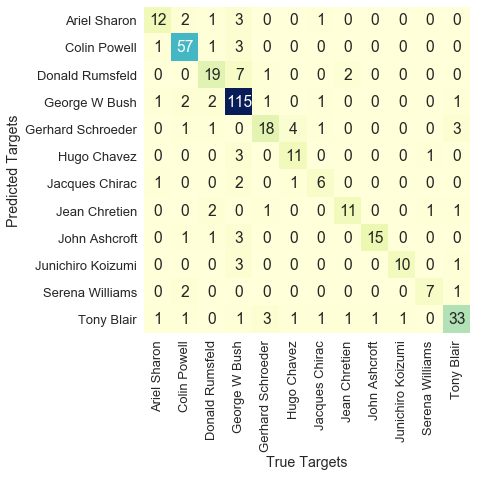

In [16]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.3)
sns.heatmap(mat_3.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ori_faces.target_names,
            yticklabels=ori_faces.target_names,
            cmap="YlGnBu")
plt.xlabel('True Targets')
plt.ylabel('Predicted Targets');